In [1]:
from train.data.supervised import ResampledAframeDataset
from ml4gw.distributions import PowerLaw
import torch
from lightning.pytorch.trainer import Trainer
from train.callbacks import ModelCheckpoint, SaveAugmentedBatch
from train.model import SupervisedAframe
from architectures.bandpass import Bandpass
from ml4gw.nn.norm import GroupNorm1DGetter
from train.metrics import TimeSlideAUROC
#from matplotlib import pyplot as plt
from lightning.pytorch.loggers import CSVLogger
import sys
sys.path.append('/home/seiya.tsukamoto/aframe/libs/priors/')
from priors.priors import end_o3_ratesandpops
import numpy as np
import os
import gc
from matplotlib import pyplot as plt
from collections import defaultdict
from torchmetrics.classification import BinaryAUROC

/usr/local/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
arch = Bandpass(classes = 64, num_ifos = 2, layers = [3, 4, 6, 3], norm_layer = GroupNorm1DGetter(groups = 16), 
                                  sample_rate = 2048, kernel_length = 4)
metric = TimeSlideAUROC(max_fpr = 1e-3, pool_length = 8, stride = 0.5)
weight_decay = 0.0
learning_rate = 0.000585
pct_lr_ramp = 0.115


batch_size = 512
batches_per_epoch = 10
num_files_per_batch = 10
chunk_size = 10000
chunks_per_epoch = 10
psd_length = 8
fftlength = None

waveform_prob = 0.277
swap_prob = 0.014
mute_prob = 0.055
left_pad = 0.25
right_pad = 0.05
snr_sampler = PowerLaw(minimum = 4, maximum = 100, index = -3)
valid_frac = 0.25
valid_stride = 0.5
num_valid_views = 5
valid_livetime = 10000



logger = CSVLogger(save_dir = '/home/seiya.tsukamoto/aframe/test', flush_logs_every_n_steps = 10)
callbacks = [ModelCheckpoint(monitor = "valid_auroc", mode = "max", save_top_k = 1, save_last = True, auto_insert_metric_name = False),
             SaveAugmentedBatch()]
max_epochs = 1
check_val_every_n_epoch = 1
log_every_n_steps = 20



ifos = ["H1", "L1"]
train_start = 1240579783
train_stop = 1241443783
test_stop = 1244035783 
max_duration = 10000
Tb = 31536000
shifts = [0, 1]
seed = 1122

streams_per_gpu = 10

kernel_length = [4, 2, 1]
prior = end_o3_ratesandpops

fftlength = None 
sample_rate = 2048
resample_rate = [2048, 1024, 2048]
fduration = 1
highpass = [32, 64, 128]
lowpass = [64, 128, 1024]
band = 0

inference_psd_length = 64
inference_sampling_rate = 4
inference_batch_size = 128

waveform_duration = 10
coalescence_time = 8
min_valid_duration = 1000.0

data_dir = '/home/seiya.tsukamoto/aframe/layered/data/train'

In [3]:
module = SupervisedAframe(arch = arch, metric = metric, learning_rate = learning_rate, 
                          pct_lr_ramp = pct_lr_ramp, weight_decay = weight_decay, verbose = True)

In [4]:
RSAD = ResampledAframeDataset(data_dir = data_dir, ifos = ifos, sample_rate = sample_rate,
                               valid_frac = valid_frac, batches_per_epoch = batches_per_epoch, 
                               num_files_per_batch = num_files_per_batch, batch_size = batch_size,
                               kernel_length = kernel_length[band], fduration = fduration, psd_length = psd_length, 
                               waveform_prob = waveform_prob, max_snr = None, snr_alpha = None,
                               left_pad = left_pad, right_pad = right_pad, fftlength = fftlength,
                               highpass = highpass[band], lowpass = lowpass[band], snr_sampler = snr_sampler, 
                               valid_stride = valid_stride, num_valid_views = num_valid_views, 
                               min_valid_duration = min_valid_duration, valid_livetime = valid_livetime, 
                               verbose = True, chunks_per_epoch = chunks_per_epoch,chunk_size = chunk_size, 
                               resample_rate = resample_rate[band])

2025-09-06 22:35:01,511 - root - INFO - Downloading data to /home/seiya.tsukamoto/aframe/layered/data/train


In [5]:
trainer = Trainer(accelerator = 'cpu', strategy = 'ddp_notebook', devices = 1, num_nodes = 1, logger = logger, 
                  callbacks = callbacks, max_epochs = 1, check_val_every_n_epoch = 1, log_every_n_steps = 20, 
                  benchmark = True, fast_dev_run = False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
#import os

In [7]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'

In [8]:
#trainer.fit(module, datamodule=RSAD)

In [9]:
#asd = torch.jit.load('/home/seiya.tsukamoto/aframe/test/model.pt')
#module.model.load_state_dict(asd.state_dict())
#module.model.eval()
#_ = module.to(torch.device('cuda:0'))

In [10]:
trainer.strategy._lightning_module = module
RSAD.trainer = trainer
RSAD.prepare_data()
RSAD.setup(stage = 'train')

2025-09-06 22:35:01,581 - AframeDataset - INFO - Validated sample rate 2048.0
2025-09-06 22:35:01,582 - AframeDataset - INFO - Constructing sample rate dependent transforms
2025-09-06 22:35:01,611 - AframeDataset - INFO - Loading validation background data
2025-09-06 22:35:02,254 - AframeDataset - INFO - Constructing validation timeslides from background segments /home/seiya.tsukamoto/aframe/layered/data/train/background/background-1241437182-6601.hdf5
2025-09-06 22:35:02,845 - h5py._conv - DEBUG - Creating converter from 3 to 5
2025-09-06 22:35:34,722 - AframeDataset - INFO - Validating on 20000 waveforms
2025-09-06 22:35:34,723 - AframeDataset - INFO - Loading 20000 validation signals
2025-09-06 22:35:35,063 - AframeDataset - INFO - Initial dataloading complete


In [ ]:
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()
for batch in ds:
    batch = batch

2025-09-06 22:35:35,289 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-09-06 22:35:37,363 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch


In [ ]:
[X], waveforms = batch
plt.plot(X[0][0][-2048*4:-2048*2])

In [46]:
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()
t1 = time.time()
for batch in ds:
    batch = RSAD.on_before_batch_transfer(batch, 10)
    batch = RSAD.on_after_batch_transfer(batch, 10)
t2 = time.time()
t2-t1

2025-08-31 09:49:32,566 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-08-31 09:49:32,573 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch


41.97001051902771

2025-08-30 17:14:01,120 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-08-30 17:14:01,910 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch
2025-08-30 17:15:05,090 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-30 17:15:05,095 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-30 17:15:05,102 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-30 17:15:05,104 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-08-30 17:15:05,104 - matplotlib.font_

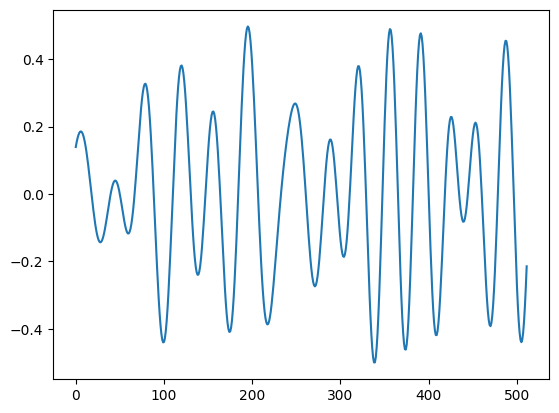

In [11]:
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        batch = RSAD.on_after_batch_transfer(batch, 10)
        X, waveforms = batch
        break
plt.plot(X[0][0][:512].cpu().numpy())

In [12]:
from scipy.signal import decimate
import torchaudio.transforms as T

In [13]:
import time

In [14]:
asd = X.numpy()
start_time = time.time()
for i in range(100):
    decimate(asd, q = 4)
end_time = time.time()
print(end_time - start_time)

0.4200248718261719


In [15]:
resampler = T.Resample(2048, 512)
start_time = time.time()
for i in range(100):
    resampler(X)
end_time = time.time()
print(end_time - start_time)

0.11811470985412598


In [16]:
f = os.path.join(RSAD.data_dir, "val_waveforms.hdf5")
waveform_set = RSAD.waveform_set_cls.read(f)

In [24]:
X.type()

'torch.FloatTensor'

In [28]:
torch.tensor(waveform_set.waveforms, dtype = torch.float).type()

'torch.FloatTensor'

In [33]:
length = len(waveform_set.waveforms)

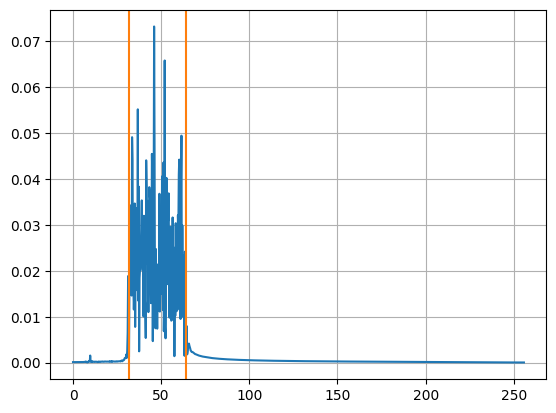

In [12]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 2048
T = 1.0 / 512.0
yf = fft(X[0][0].cpu().numpy())
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(32, c = 'C1')
plt.axvline(64, c = 'C1')
plt.grid()
plt.show()

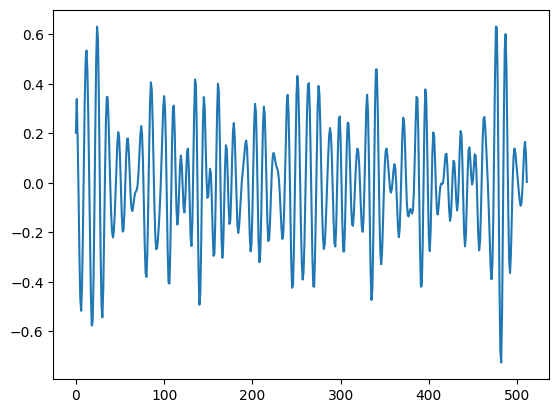

In [24]:
RSAD.trainer.training = False
RSAD.trainer.validating = True
ds = RSAD.val_dataloader()
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        [background, _, timeslide_idx], [signals] = batch
        batch = [background.to(torch.device('cuda:0')), 0, timeslide_idx], [signals.to(torch.device('cuda:0'))]
        del background, timeslide_idx, signals
        batch = RSAD.on_after_batch_transfer(batch, 10)
        shift, X_bg, X_inj = batch
        break
plt.plot(X_inj[0][0][0][:512].cpu().numpy())

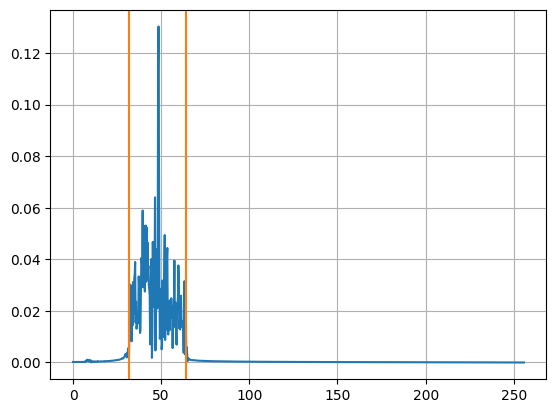

In [15]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 2048
T = 1.0 / 512.0
yf = fft(X_inj[0][0][0].cpu().numpy())
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(32, c = 'C1')
plt.axvline(64, c = 'C1')
plt.grid()
plt.show()

In [16]:
RSAD.trainer.training = False
RSAD.trainer.validating = True
ds = RSAD.val_dataloader()

i = 0
metric = TimeSlideAUROC(max_fpr = 1e-3, pool_length = 8, stride = 0.5)
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        [background, _, timeslide_idx], [signals] = batch
        batch = [background.to(torch.device('cuda:0')), 0, timeslide_idx], [signals.to(torch.device('cuda:0'))]
        del background, timeslide_idx, signals
        batch = RSAD.on_after_batch_transfer(batch, 10)
        shift, X_bg, X_inj = batch
        del batch
        y_bg = module.score(X_bg)
        del X_bg
        num_views, batch, *shape = X_inj.shape
        X_inj = X_inj.view(num_views * batch, *shape)
        
        y_fg = module.score(X_inj)
        y_fg = y_fg.view(num_views, batch)
        del num_views, batch, shape
        y_fg = y_fg.mean(0)
        y_bg = y_bg.cpu()
        y_fg = y_fg.cpu()
        metric.update(shift, y_bg.cpu(), y_fg.cpu())
        i += 1
        if i > 10:
            break

In [18]:
foreground, background = [], defaultdict(list)
for i, bg, fg in zip(metric.shifts, metric.background, metric.foreground):
    foreground.append(fg)
    background[i.item()].append(bg)
foreground = torch.cat(foreground)

In [19]:
pooled_background = []
for bg in background.values():
    bg = torch.cat(bg).view(1, 1, -1)
    bg = metric.pool(bg).view(-1)
    pooled_background.append(bg)
background = torch.cat(pooled_background)

In [20]:
y_pred = torch.cat([background, foreground])
y = torch.zeros_like(y_pred)
y[len(background) :] = 1
idx = torch.randperm(len(y_pred))
y_pred = y_pred[idx]
y = y[idx]

In [22]:
metric.metric(y_pred, y)

tensor(0.4997)

In [23]:
foreground

tensor([0.3513, 0.3519, 0.3506, 0.3520, 0.3491, 0.3486, 0.3455, 0.3477, 0.3468,
        0.3435, 0.3397, 0.3462, 0.3458, 0.3455, 0.3452, 0.3444, 0.3466, 0.3385,
        0.3427, 0.3419, 0.3409, 0.3451, 0.3449, 0.3460, 0.3444, 0.3484, 0.3460,
        0.3280, 0.3488, 0.3502, 0.3494, 0.3419, 0.3527, 0.3480, 0.3523, 0.3521,
        0.3470, 0.3413, 0.3505, 0.3482, 0.3491, 0.3490, 0.3470, 0.3461, 0.3437,
        0.3487, 0.3415, 0.3480, 0.3491, 0.3484, 0.3519, 0.3381, 0.3521, 0.3521,
        0.3537, 0.3495, 0.3499, 0.3504, 0.3482, 0.3480, 0.3499, 0.3499, 0.3518,
        0.3507, 0.3505, 0.3487, 0.3514, 0.3492, 0.3454, 0.3468, 0.3472, 0.3423,
        0.3469, 0.3458, 0.3466, 0.3466, 0.3470, 0.3494, 0.3471, 0.3484, 0.3450,
        0.3453, 0.3476, 0.3463, 0.3443, 0.3484, 0.3443, 0.3464, 0.3457, 0.3458,
        0.3466, 0.3457, 0.3471, 0.3487, 0.3499, 0.3469, 0.3478, 0.3481, 0.3472,
        0.3492, 0.3511, 0.3493, 0.3480, 0.3520, 0.3532, 0.3544, 0.3558, 0.3547,
        0.3463, 0.3528])

In [21]:
y

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')